<a href="https://colab.research.google.com/github/MarcelLopes7/Machine-Learning---Analytics/blob/main/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning & Analytics
## Autor: Marcel Antonio Lopes Pereira

## Introdução

Esse MVP consiste na construção de um modelo de machine learning a partir de um dataset com dados de usuários de uma academia de exercícios físicos (Gym Members Exercise Dataset). Para compreensão do dataset em questão, os respectivos atributos são listados a seguir:

**Idade**: Idade do usuário da academia.

**Gênero**: Gênero do usuário da academia (Masculino ou Feminino).

**Peso (kg)**: Peso do usuário em quilogramas.

**Altura (m)**: Altura do usuário em metros.

**BPM Máx**: Frequência cardíaca máxima (batimentos por minuto) durante as sessões de treino.

**BPM Médio**: Frequência cardíaca média durante as sessões de treino.

**BPM Repouso**: Frequência cardíaca em repouso antes do treino.

**Duração da Sessão (horas)**: Duração de cada sessão de treino em horas.

**Calorias Queimadas**: Total de calorias queimadas durante cada sessão.

**Tipo de Treino**: Tipo de treino realizado (por exemplo, Cardio, Força, Yoga, HIIT).

**Percentual de Gordura**: Percentual de gordura corporal do usuário.

**Consumo de Água (litros)**: Consumo diário de água durante os treinos.

**Frequência de Treino (dias/semana)**: Número de sessões de treino por semana.

**Nível de Experiência**: Nível de experiência, de iniciante (1) a especialista (3).

**IMC**: Índice de Massa Corporal, calculado a partir da altura e do peso.

A partir da descrição dos atributos, é possível identificar várias ideias de problemas para ser solucinados. Foi escolhido um problema que consiste na predição do número de calorias queimadas por um usuário. Como o resultado dessa predição é um valor contínuo, esse é um problema de regressão, sendo então de aprendizado supervisionado. Inicialmente, serão explorados esses dados para entender suas distruibuições e correlações. A partir disso, será descrito o procedimento de tratamento e preparação dos mesmos para construção do modelo. Todo o processo de construção do modelo será detalhado, com suas definições e decisões tomadas.

## Importação das bibliotecas

Com os atributos definidos, o código do programa inicia com a importação das bibliotecas python que serão utilizadas nesse projeto. A seguir, são definidas algumas funções que serão utilizadas ao longo do código.

In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import missingno as ms # para tratamento de missings
import math

## Importação das bibliotecas do scikitlearn para construção do modelo
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer

Essa biblioteca inclui um recurso para tradução de idiomas.

In [2]:
!pip install googletrans==4.0.0-rc1
from googletrans import Translator

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=1c4daf95dcd5fdd2e46b2f0143cceed7b10d2f3362ace9268acbd230a8626d0e
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Succ

## Funções utilizadas no programa

São definidas a seguir as funções utilizadas no código do programa para realizar algumas tarefas necessárias no projeto. A primeira delas é a função que realização normalização das colunas do dataset, removendo espaço, quebras de linha e caracteres especiais. Após definida essa função, são definidas funções para realizar a tradução do nome das colunas do inglês para o português.

In [3]:
# Função para normalizar o nome das colunas
# (remover espaços, quebras de linha e caracteres especiais)
def normalizar_coluna(coluna):
    # Remover quebras de linha, espaços extras e
    # caracteres especiais como hifens
    return re.sub(r'[\s\n\-_]+', ' ', coluna).strip().lower()

# Função para renomear as colunas e identificar as
# que não foram traduzidas
def traduzir_colunas(df, colunas_traduzidas):
    colunas_nao_traduzidas = []

    def traduzir_nome_coluna(coluna):
        nome_normalizado = normalizar_coluna(coluna)
        if nome_normalizado in colunas_traduzidas:
            return colunas_traduzidas[nome_normalizado]
        else:
            colunas_nao_traduzidas.append(coluna)  #
            # Adicionar colunas não traduzidas à lista
            return coluna  # Retorna o nome original se não for encontrado

    # Renomear as colunas
    df_traduzido = df.rename(columns=traduzir_nome_coluna)

    if colunas_nao_traduzidas:
        print("Colunas que não foram traduzidas:",
              colunas_nao_traduzidas)
    else:
        print("Todas as colunas foram traduzidas com sucesso.")

    return df_traduzido

Essa função realiza a tradução das palavras numa coluna específica selecionada a partir do dataframe.

In [4]:
# Inicializar o tradutor
translator = Translator()

# Função para traduzir colunas usando Google Translator
def traduzir_coluna(df, colunas):
    for coluna in colunas: # Iterate through the list of columns
        # Verifica se a coluna existe
        if coluna in df.columns:
            # Traduz cada valor da coluna
            df[coluna] = df[coluna].apply(
                lambda valor: translator.translate(x, dest='pt').text )
    return df  # Return the modified dataframe

Essa função é definida para remover colunas somente com variáveis do tipo string, caso seja necessário utilizar o dataset para realizar análises extritamente númericas, como na criação de uma matriz de correlação.

In [5]:
# Função para remover colunas object
def remover_colunas_object(df):

    # Selecionar apenas colunas que não são do tipo 'object'
    df_numerico = df.select_dtypes(exclude=['object'])

    return df_numerico

Função para construir bloxplots de todas as colunas numéricas em subplots organizados.

In [6]:
def boxplots(df_numerico, num_boxplots_por_linha=2,
             figsize=(12, 6), cor_paleta='viridis'):
    """
    Função para criar boxplots de todas as colunas numéricas em
    subplots organizados.

    Parâmetros:
    - df_numerico: DataFrame contendo apenas colunas numéricas.
    - num_boxplots_por_linha: Número de boxplots por linha
      (padrão é 2).
    - figsize: Tamanho base da figura (padrão é (12, 6)).
    - cor_paleta: Paleta de cores para os boxplots (padrão é
      'viridis').
    """
    # Número de colunas no dataframe
    num_colunas = df_numerico.shape[1]

    # Definir o número de linhas necessárias
    num_linhas = math.ceil(num_colunas / num_boxplots_por_linha)

    # Ajustar o tamanho da figura
    fig, axes = plt.subplots(
        nrows=num_linhas, ncols=num_boxplots_por_linha,
        figsize=(figsize[0], num_linhas * figsize[1])
    )

    # Flatten o array de eixos para simplificar a iteração
    axes = axes.flatten()

    # Definindo o estilo do Seaborn
    sns.set_theme(style="whitegrid")

    # Iterar sobre cada coluna do dataframe e criar um boxplot
    for i, col in enumerate(df_numerico.columns):
        sns.boxplot(x=df_numerico[col], ax=axes[i], palette=cor_paleta)
        axes[i].set_title(f'Boxplot da coluna: {col}', fontsize=12)
        axes[i].set_xlabel('')  # Remover o rótulo do eixo x
        axes[i].set_ylabel('Valores', fontsize=10)
        axes[i].grid(True)  # Adiciona grid para melhor visualização

    # Remover eixos não usados, se houver
    if num_colunas % num_boxplots_por_linha != 0:
        for j in range(num_colunas, len(axes)):
            fig.delaxes(axes[j])

    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

Essa função constrói histogramas e density plots a partir de atributos selecionados do dataframe

In [7]:
# Função para gerar histogramas e density plots com títulos
# ajustados para nomes longos
def hist_density(df, hist_color='blue', kde_color='red',
                 max_title_length=30):
    colunas_numericas = df.select_dtypes(include='number').columns

    for coluna in colunas_numericas:
        # Ajustar o tamanho do título se for muito longo
        title_hist = f"Histograma de {coluna}"
        title_density = f"Density Plot de {coluna}"

        if len(coluna) > max_title_length:
            title_hist = f"Histograma de\n{coluna}"
            title_density = f"Density Plot de\n{coluna}"

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Gerar o histograma
        sns.histplot(
            df[coluna].dropna(), bins=30, kde=False,
            color=hist_color, ax=axes[0]
        )
        axes[0].set_title(
            title_hist,
            fontsize=12 if len(coluna) > max_title_length else 14
        )
        axes[0].set_xlabel(coluna, fontsize=12)
        axes[0].set_ylabel('Frequência', fontsize=12)

        # Gerar o density plot
        sns.kdeplot(
            df[coluna].dropna(), shade=True, color=kde_color,
            ax=axes[1]
        )
        axes[1].set_title(
            title_density,
            fontsize=12 if len(coluna) > max_title_length else 14
        )
        axes[1].set_xlabel(coluna, fontsize=12)
        axes[1].set_ylabel('Densidade', fontsize=12)

        # Ajustando o layout para evitar sobreposição
        fig.tight_layout(pad=6.0)  # Aumenta o espaçamento entre gráficos

        # Exibir os gráficos
        plt.show()

Essa função realiza a seleção dos melhores atributos para treinamento do modelo

In [8]:
# Função para criar e rodar pipelines apenas com seleção de features
def run_feature_selection_comparison(X_train, y_train, model, k_values=range(5, 20), cv=10):
    """Compara um modelo com diferentes valores de k para seleção de features."""
    results = {}
    selected_features_per_k = {}

    print(f"\nModelo: {model.__class__.__name__}")

    # Testar diferentes valores de k
    for k in k_values:
        # Seleção de features separada para registrar os atributos selecionados
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(X_train, y_train)
        selected_features = X_train.columns[selector.get_support()]

        # Construir a pipeline
        steps = [('feature_selection', selector),
                 ('model', model)]
        pipeline = Pipeline(steps)

        # Validação cruzada
        scores = cross_val_score(
            pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
        )

        # Armazenar os resultados
        results[k] = {
            'MSE Médio': -np.mean(scores),
            'MSE Desvio': np.std(scores)
        }
        selected_features_per_k[k] = list(selected_features)

        print(f"k={k} -> MSE Médio: {-np.mean(scores):.4f}, "
              f"Desvio: {np.std(scores):.4f}")
        print(f"Atributos Selecionados: {', '.join(selected_features)}")

    # Determinar o k com menor erro
    best_k = min(results, key=lambda k: results[k]['MSE Médio'])
    best_features = selected_features_per_k[best_k]
    print(f"\nMelhor k: {best_k}")
    print(f"Atributos Selecionados para k={best_k}: {', '.join(best_features)}")

    return results, best_k, best_features

Essa função constrói uma pipeline e avalia o desempenho de diversos modelos de regressão a partir de uma base de treino especificada e de atributos selecionados, utilizando validação cruzada no processo

In [9]:
def evaluate_models_on_training(X_train, y_train, models, scalers, selected_features, cv=10):
    """
    Avalia modelos de regressão com diferentes escalonadores usando validação cruzada.

    Parâmetros:
        - X_train: DataFrame com os atributos de treino.
        - y_train: Série ou array com o alvo de treino.
        - models: Dicionário de modelos de regressão (nome -> instância).
        - scalers: Dicionário de escalonadores (nome -> instância ou None).
        - selected_features: Lista com os nomes das features selecionadas.
        - cv: Número de folds para a validação cruzada.

    Retorna:
        - results_df: DataFrame com a média e desvio padrão dos resultados.
        - all_cv_results_df: DataFrame com todos os resultados de validação cruzada (para boxplots).
    """
    results = []
    all_cv_results = []

    for scaler_name, scaler in scalers.items():
        print(f"\nCenário: {scaler_name}")

        # Filtrar os dados apenas com as features selecionadas
        X_train_selected = X_train[selected_features]

        # Escalonar dados, se necessário
        if scaler is not None:
            scaler.fit(X_train_selected)
            X_train_selected = scaler.transform(X_train_selected)

        # Testar cada modelo
        for model_name, model in models.items():
            print(f"\nModelo: {model_name}")

            # Construir a pipeline
            pipeline = Pipeline([('model', model)])

            # Validação cruzada
            scores = cross_val_score(
                pipeline, X_train_selected, y_train, cv=cv,
                scoring='neg_mean_squared_error', n_jobs=-1
            )

            # Calcular RMSE médio e desvio padrão
            rmse_cv = np.sqrt(-np.mean(scores))  # Média do RMSE
            rmse_std = np.sqrt(-scores).std()   # Desvio padrão do RMSE
            results.append({
                'Cenário': scaler_name,
                'Modelo': model_name,
                'RMSE CV': rmse_cv,
                'Desvio': rmse_std
            })

            # Registrar todos os resultados individuais de validação cruzada (em termos de RMSE)
            for fold_score in -scores:
                all_cv_results.append({
                    'Cenário': scaler_name,
                    'Modelo': model_name,
                    'RMSE': np.sqrt(fold_score)
                })

            print(f"RMSE CV: {rmse_cv:.4f}, Desvio: {rmse_std:.4f}")

    # Consolidar resultados em DataFrames
    results_df = pd.DataFrame(results).sort_values(by='RMSE CV')
    all_cv_results_df = pd.DataFrame(all_cv_results)

    return results_df, all_cv_results_df

Essa função constrói curvas de aprendizado para os modelos de Machine Learning selecionados.

In [11]:
def plot_learning_curves(X_train, y_train, models, scalers, selected_features, top_models, cv=10):
    """
    Gera as curvas de aprendizado para os 5 melhores modelos.

    Parâmetros:
        - X_train: DataFrame com os atributos de treino.
        - y_train: Série ou array com o alvo de treino.
        - models: Dicionário com os modelos treinados.
        - scalers: Dicionário de escalonadores.
        - selected_features: Lista com as features selecionadas.
        - top_models: DataFrame com os 5 melhores modelos (filtrado).
        - cv: Número de folds para validação cruzada.
    """
    fig, axes = plt.subplots(1, len(top_models), figsize=(20, 6), sharey=True)
    axes = axes.ravel()  # Para facilitar a iteração

    # Para cada um dos 5 melhores modelos
    for idx, (_, row) in enumerate(top_models.iterrows()):
        model_name = row['Modelo']
        scaler_name = row['Cenário']
        print(f"\nPlotando curva de aprendizado para: {model_name} com escalonador {scaler_name}")

        # Configurar os dados com o escalonador
        scaler = scalers[scaler_name]
        X_train_selected = X_train[selected_features]
        if scaler is not None:
            scaler.fit(X_train_selected)
            X_train_selected = scaler.transform(X_train_selected)

        # Obter o modelo
        model = models[model_name]

        # Calcular a curva de aprendizado
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train_selected, y_train, cv=cv, scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )

        # Transformar as pontuações de erro negativo para RMSE
        train_rmse = np.sqrt(-train_scores)
        val_rmse = np.sqrt(-val_scores)

        # Média e desvio padrão para treino e validação
        train_mean = train_rmse.mean(axis=1)
        train_std = train_rmse.std(axis=1)
        val_mean = val_rmse.mean(axis=1)
        val_std = val_rmse.std(axis=1)

        # Plotar a curva de aprendizado
        ax = axes[idx]
        ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Erro de Treino')
        ax.plot(train_sizes, val_mean, 'o-', color='orange', label='Erro de Validação')
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
        ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)
        ax.set_title(f"{model_name} - {scaler_name}")
        ax.set_xlabel("Tamanho do Conjunto de Treino")
        ax.set_ylabel("RMSE")
        ax.legend(loc="best")
        ax.grid()

    # Ajustar layout
    plt.tight_layout()
    plt.show()

Esta função constrói curvas de aprendizado após a otimização dos hiperparâmetros

In [12]:
def plot_learning_curves_after_grid_search(
    X_train, y_train, models, scalers, selected_features, grid_search_results, cv=10):
    """
    Gera as curvas de aprendizado para os melhores modelos após o Grid Search.

    Parâmetros:
        - X_train: DataFrame com os atributos de treino.
        - y_train: Série ou array com o alvo de treino.
        - models: Dicionário com os modelos ajustados.
        - scalers: Dicionário de escalonadores.
        - selected_features: Lista com as features selecionadas.
        - grid_search_results: DataFrame com os resultados do Grid Search.
        - cv: Número de folds para validação cruzada.
    """
    # Filtrar os 5 melhores modelos com menor RMSE no conjunto de validação
    top_models = grid_search_results.nsmallest(5, 'RMSE no Validação')

    # Preparar a visualização
    fig, axes = plt.subplots(1, len(top_models), figsize=(20, 6), sharey=True)
    axes = axes.ravel()

    # Gerar as curvas para os 5 melhores modelos
    for idx, (_, row) in enumerate(top_models.iterrows()):
        model_name = row['Modelo']
        scaler_name = row['Cenário']
        best_params = row['Melhores Hiperparâmetros']
        print(f"\nPlotando curva de aprendizado para: {model_name} com escalonador {scaler_name}")

        # Configurar os dados com o escalonador
        scaler = scalers[scaler_name]
        X_train_selected = X_train[selected_features]
        if scaler is not None:
            scaler.fit(X_train_selected)
            X_train_selected = scaler.transform(X_train_selected)

        # Configurar o modelo com os melhores hiperparâmetros encontrados
        model = models[model_name]
        model.set_params(**best_params)

        # Calcular a curva de aprendizado
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train_selected, y_train, cv=cv, scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )

        # Transformar as pontuações de erro negativo para RMSE
        train_rmse = np.sqrt(-train_scores)
        val_rmse = np.sqrt(-val_scores)

        # Média e desvio padrão para treino e validação
        train_mean = train_rmse.mean(axis=1)
        train_std = train_rmse.std(axis=1)
        val_mean = val_rmse.mean(axis=1)
        val_std = val_rmse.std(axis=1)

        # Plotar a curva de aprendizado
        ax = axes[idx]
        ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Erro de Treino')
        ax.plot(train_sizes, val_mean, 'o-', color='orange', label='Erro de Validação')
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
        ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)
        ax.set_title(f"{model_name} - {scaler_name}")
        ax.set_xlabel("Tamanho do Conjunto de Treino")
        ax.set_ylabel("RMSE")
        ax.legend(loc="best")
        ax.grid()

    # Ajustar layout
    plt.tight_layout()
    plt.show()

## Análise Exploratória e Preparação dos Dados



O dataset é importado para o notebook e convertido em dataframe. Em seguida, são exibidas as primeiras linhas do dataframe.

In [28]:
# URL de importação do dataset
url = (
    "https://raw.githubusercontent.com/MarcelLopes7/"
    "Machine-Learning---Analytics/refs/heads/main/"
    "gym_members_exercise_tracking.csv"
)

# Leitura do arquivo
dataframe = pd.read_csv(url)

# Visualização de todas as colunas do dataframe
pd.set_option(
    'display.max_columns', None
)

In [29]:
# Exibição das primeiras linhas do dataset
dataframe.head(10)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
5,56,Female,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55
6,36,Male,70.3,1.72,174,169,73,1.49,1385.0,Cardio,21.3,2.3,3,2,23.76
7,40,Female,69.7,1.51,189,141,64,1.27,895.0,Cardio,30.6,1.9,3,2,30.57
8,28,Male,121.7,1.94,185,127,52,1.03,719.0,Strength,28.9,2.6,4,2,32.34
9,28,Male,101.8,1.84,169,136,64,1.08,808.0,Cardio,29.7,2.7,3,1,30.07


In [30]:
# Exibição das últimas linhas do dataset
dataframe.tail(10)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
963,57,Female,43.8,1.75,180,160,73,1.39,1001.0,Cardio,25.1,1.7,2,1,14.30
964,56,Female,64.2,1.69,190,137,61,1.99,1227.0,Cardio,19.6,2.7,5,3,22.48
965,23,Female,44.1,1.62,196,122,58,0.58,354.0,Yoga,25.7,2.7,2,1,16.80
966,23,Male,87.3,1.91,164,129,58,1.87,1327.0,HIIT,11.8,3.5,5,3,23.93
967,20,Male,55.0,1.60,172,168,67,1.12,1035.0,Yoga,24.0,3.2,4,2,21.48
968,24,Male,87.1,1.74,187,158,67,1.57,1364.0,Strength,10.0,3.5,4,3,28.77
969,25,Male,66.6,1.61,184,166,56,1.38,1260.0,Strength,25.0,3.0,2,1,25.69
970,59,Female,60.4,1.76,194,120,53,1.72,929.0,Cardio,18.8,2.7,5,3,19.50
971,32,Male,126.4,1.83,198,146,62,1.10,883.0,HIIT,28.2,2.1,3,2,37.74
972,46,Male,88.7,1.63,166,146,66,0.75,542.0,Strength,28.8,3.5,2,1,33.38


In [31]:
# Mostra as dimensões do dataframe
dataframe.shape

(973, 15)

In [32]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [33]:
# Identificar colunas categóricas (tipo object ou categóricas)
categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns

# Contar e exibir o número de classes únicas para cada coluna categórica
for col in categorical_columns:
    num_classes = dataframe[col].nunique()
    print(f"A coluna '{col}' possui {num_classes} classe(s).")

A coluna 'Gender' possui 2 classe(s).
A coluna 'Workout_Type' possui 4 classe(s).


O dataset possui 973 linhas e 15 colunas, representados os atributos. Dentre essas colunas, 13 são númericas e 2 são catergóricas (Gênero e Tipo de Treino). O atributo Gender possui 2 classes ( Male e Female) e o atributo Workout_Type possui 4 classes (HIIT, Strenght, Yoga e Cardio).

Para facilitar a visualização das informações no mesmo idioma desse projeto, é necessário realizar a tradução da nomenclatura dos atributos no dataframe. São definidos os nomes originais das colunas com suas respectivas traduções. Em seguida, a função de tradução é chamada.

In [34]:
# Dicionário atualizado com as colunas que estavam com formatações diferentes
colunas_traduzidas = {
    "Age": "Idade",
    "Gender": "Gênero",
    "Weight (kg)": "Peso (kg)",
    "Height (m)": "Altura (m)",
    "Max_BPM": "BPM Máx",
    "Avg_BPM": "BPM Médio",
    "Resting_BPM": "BPM Repouso",
    "Session_Duration (hours)": "Duração da Sessão (horas)",
    "Calories_Burned": "Calorias Queimadas",
    "Workout_Type": "Tipo de Treino",
    "Fat_Percentage": "Percentual de Gordura",
    "Water_Intake (liters)": "Consumo de Água (litros)",
    "Workout_Frequency (days/week)": "Frequência de Treino (dias/semana)",
    "Experience_Level": "Nível de Experiência",
    "BMI": "IMC",
}

# Normalizar dicionário de tradução
colunas_traduzidas_normalizado = {
    normalizar_coluna(k): v for k, v in colunas_traduzidas.items()
}

# Aplicar a função ao dataframe
dataframe = traduzir_colunas(dataframe,
                              colunas_traduzidas_normalizado)

Todas as colunas foram traduzidas com sucesso.


In [42]:
# Mapeamento das traduções
translation_map = {
    'Male': 'Masculino',
    'Female': 'Feminino',
    'Cardio': 'Cardio',  # "Cardio" permanece igual
    'Strength': 'Força',
    'Hiit': 'HIIT',
    'Yoga': 'Yoga'
}

# Traduzir linha por linha
for col in dataframe.columns:
    dataframe[col] = dataframe[col].apply(lambda x: translation_map.get(x, x))

dataframe.head(15)

,Idade,Gênero,Peso (kg),Altura (m),BPM Máx,BPM Médio,BPM Repouso,Duração da Sessão (horas),Calorias Queimadas,Tipo de Treino,Percentual de Gordura,Consumo de Água (litros),Frequência de Treino (dias/semana),Nível de Experiência,IMC
0,56,Masculino,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Feminino,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Feminino,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Masculino,53.2,1.70,190,164,56,0.59,532.0,Força,28.8,2.1,3,1,18.41
4,38,Masculino,46.1,1.79,188,158,68,0.64,556.0,Força,29.2,2.8,3,1,14.39
5,56,Feminino,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55
6,36,Masculino,70.3,1.72,174,169,73,1.49,1385.0,Cardio,21.3,2.3,3,2,23.76
7,40,Feminino,69.7,1.51,189,141,64,1.27,895.0,Cardio,30.6,1.9,3,2,30.57
8,28,Masculino,121.7,1.94,185,127,52,1.03,719.0,Força,28.9,2.6,4,2,32.34
9,28,Masculino,101.8,1.84,169,136,64,1.08,808.0,Cardio,29.7,2.7,3,1,30.07


Após a tradução, dos nomes dos atributos e das classes, um resumo estatístico do dataset pode ser visualização para extração de algumas informações sobre a distribuição dos dados.

In [43]:
# Resumo estatístico do dataframe
dataframe.describe()

,Idade,Peso (kg),Altura (m),BPM Máx,BPM Médio,BPM Repouso,Duração da Sessão (horas),Calorias Queimadas,Percentual de Gordura,Consumo de Água (litros),Frequência de Treino (dias/semana),Nível de Experiência,IMC
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,3.321686,1.809866,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,0.913047,0.739693,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,3.000000,1.000000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,3.000000,2.000000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,4.000000,2.000000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000


A partir do resumo estatístico do dataset, é possível extrair algumas informações relevantes:


*   Todos os atributos possuem valores preenchidos em todas as linhas, de forma que não será necessário considerar a exclusão de linhas com dados faltantes.
*   Como não há valores mínimos iguais a zero, pode-se concluir que com todos os dados preenchidos, não há valores nulos no dataset. Um comando a seguir comprova essa afirmação.



In [44]:
dataframe.isnull().sum()

,0
Idade,0
Gênero,0
Peso (kg),0
Altura (m),0
BPM Máx,0
BPM Médio,0
BPM Repouso,0
Duração da Sessão (horas),0
Calorias Queimadas,0
Tipo de Treino,0


Como o dataframe não possui valores nulos, não será necessário um tratamento dos dados em relação a essa questão.

Após essa verificação, são gerados gráficos bloxplot para entender a distribuição dos dados em cada atributo.

In [45]:
# Criando um novo dataframe com as colunas númericas
df_numerico = remover_colunas_object(dataframe)

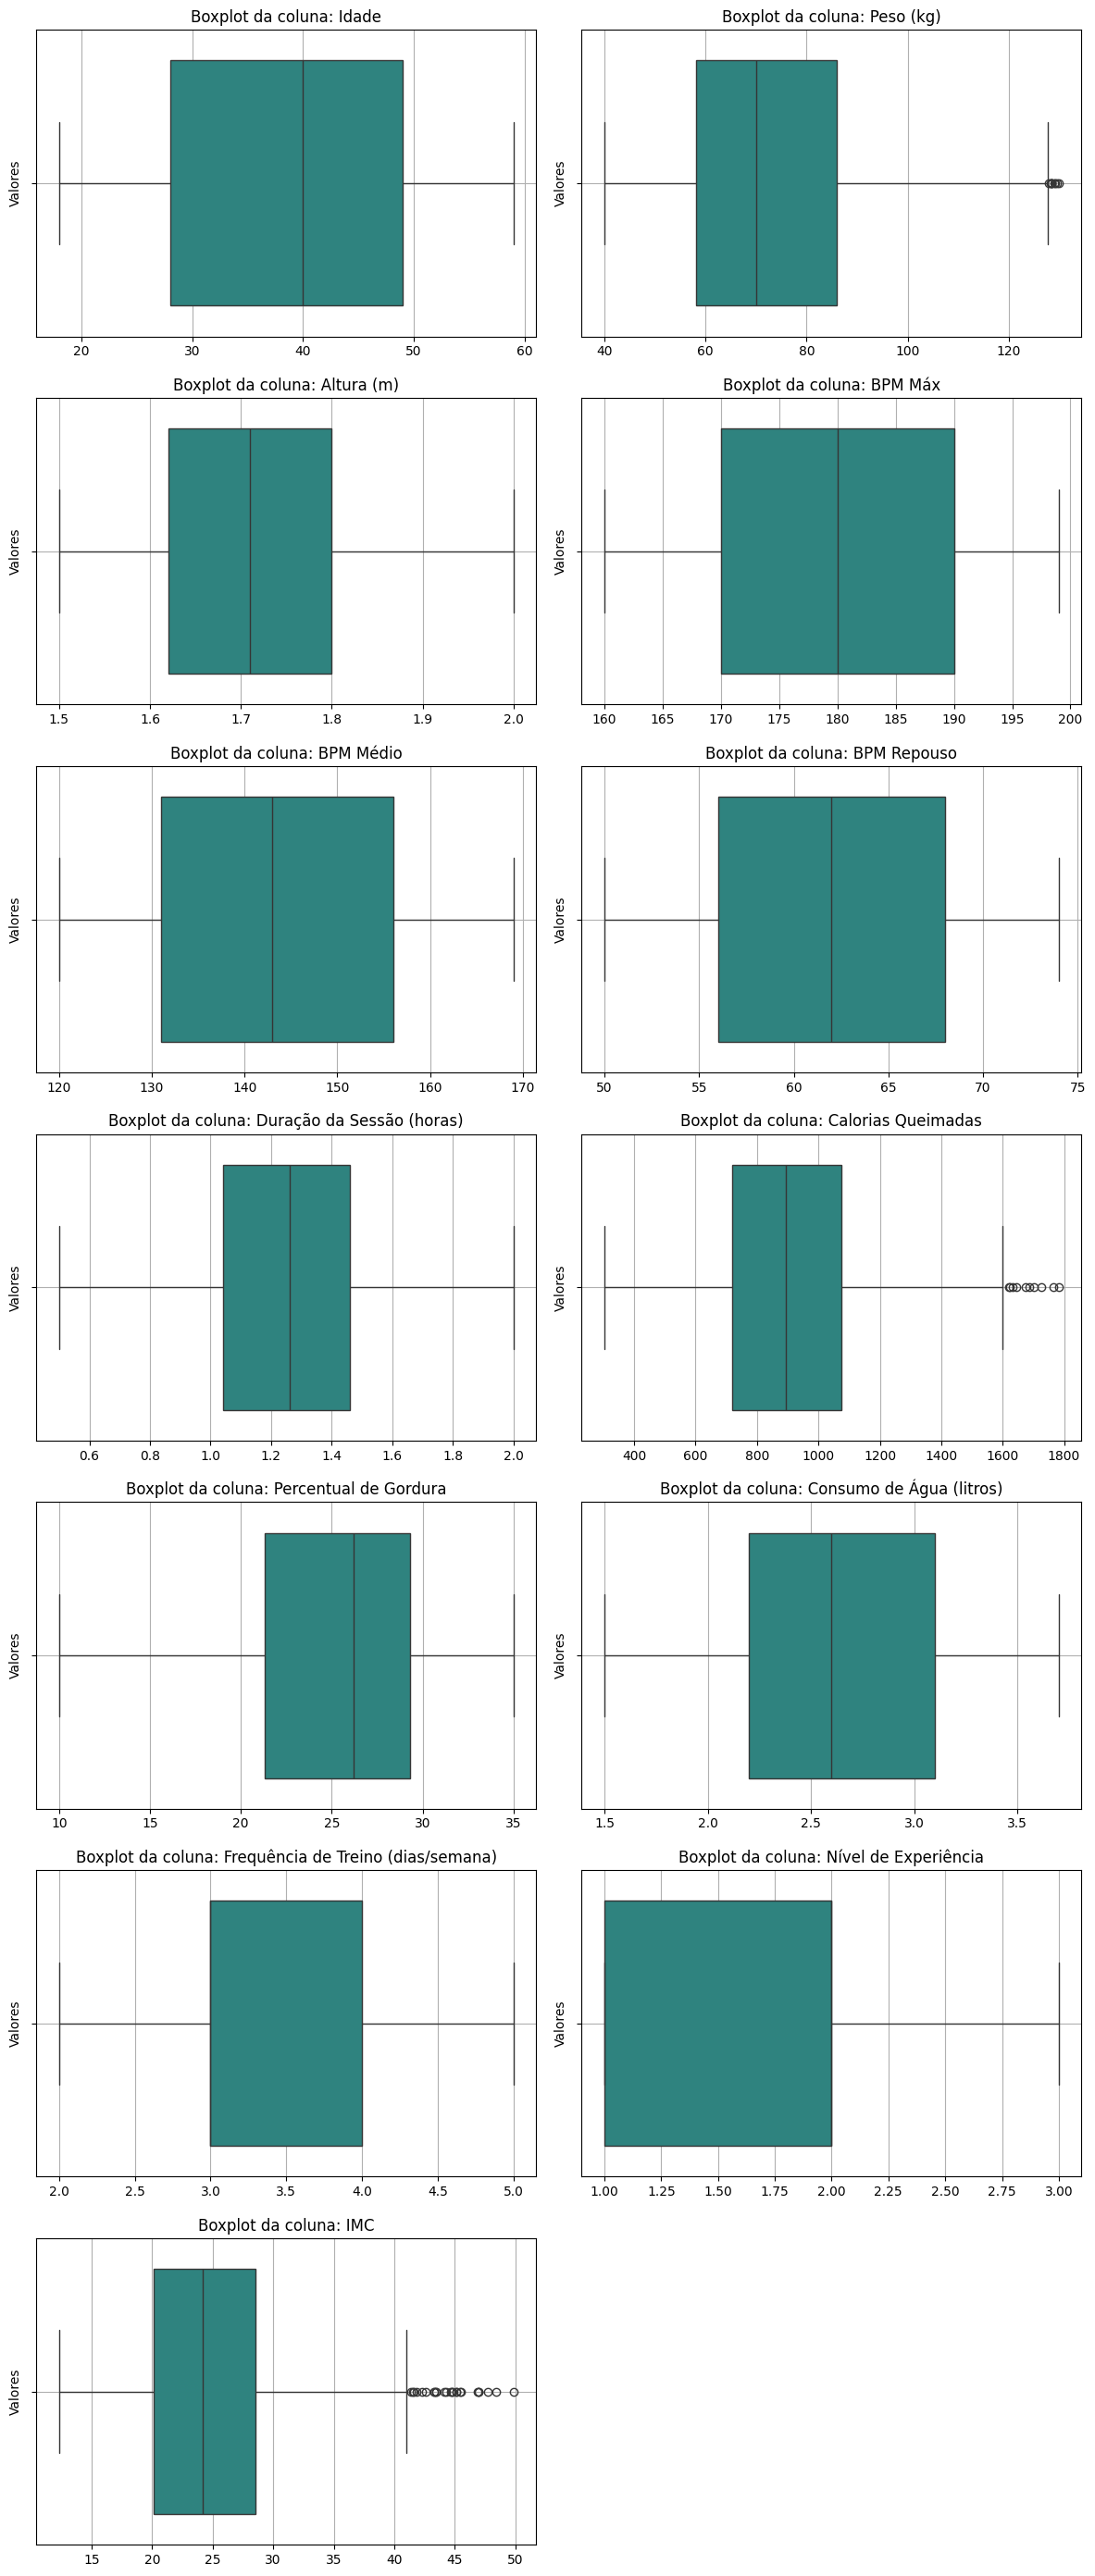

In [46]:
# Chamada da função para plotar os boxplots
boxplots(df_numerico, 2, (12,4))

Após exploração dos atributos por meio da visualização das distribuições em boxplots, verificou-se a presença de outliers em três deles: Peso (kg), Calorias Queimadas (atributo alvo) e IMC.
Como esses dados são necessários para a modelagem do problema, não serão descartados. Desse modo, será necessária a implementação de modelos mais robustos de forma que os outliers não influenciem significamente nos resultados.

São gerados também gráficos para entender a tipo de distribuição desses dados.

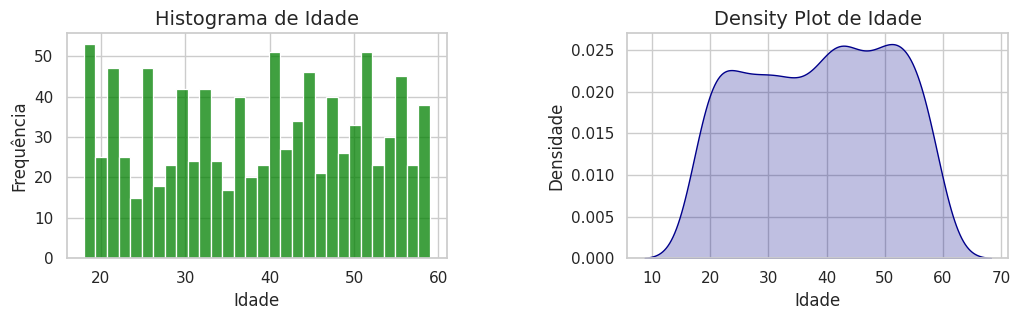

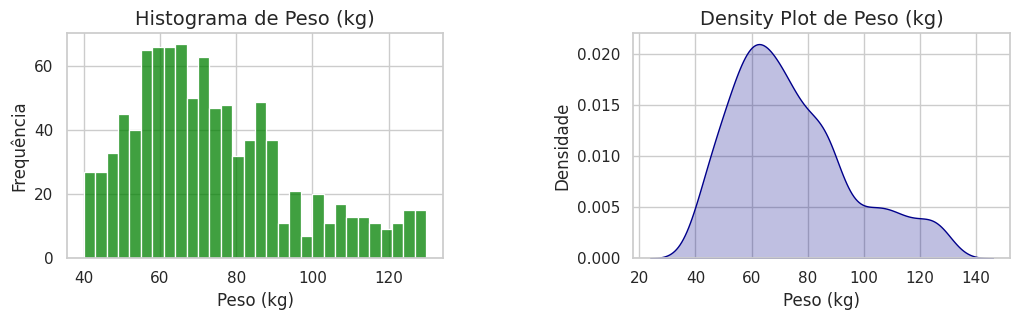

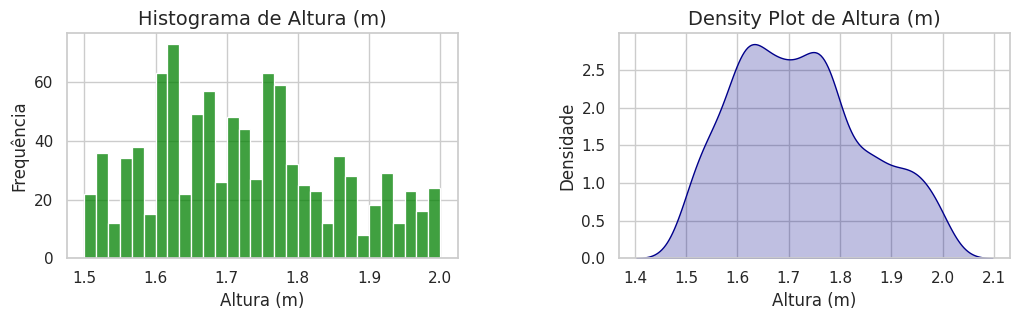

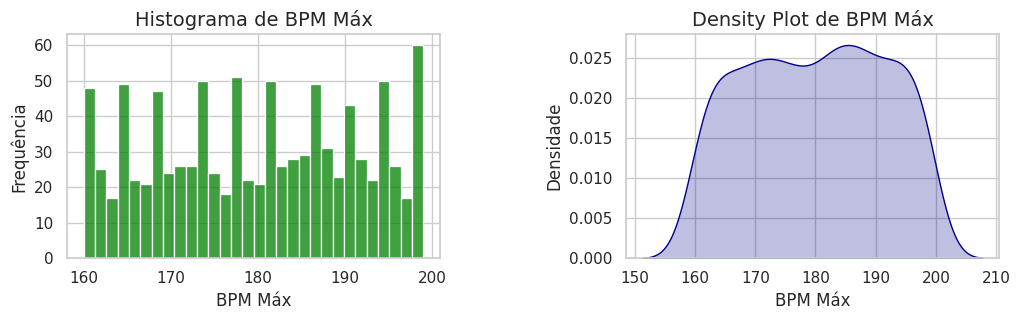

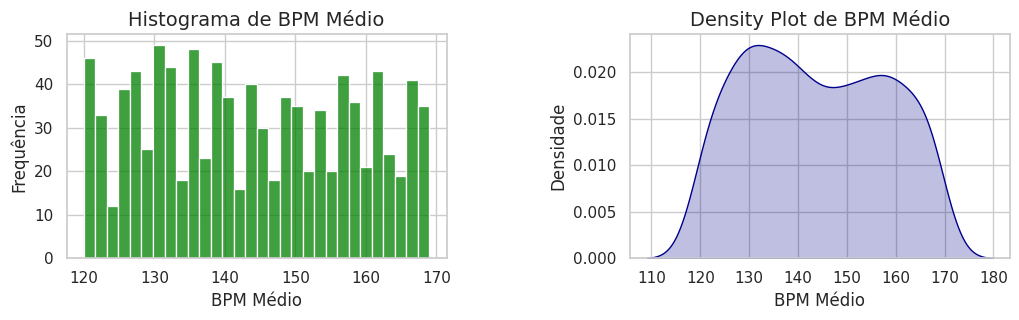

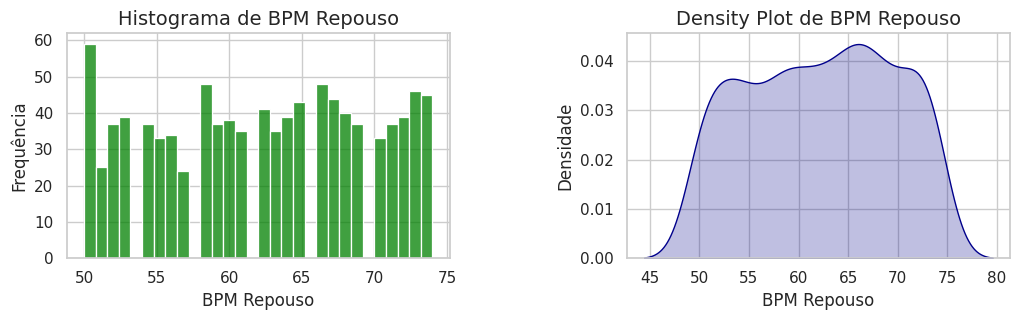

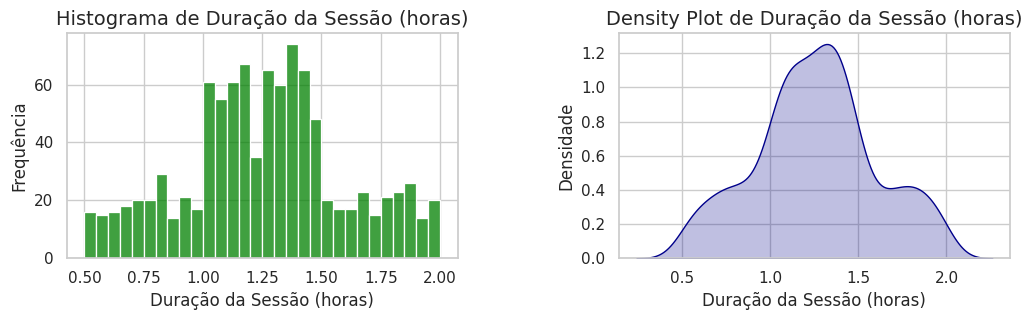

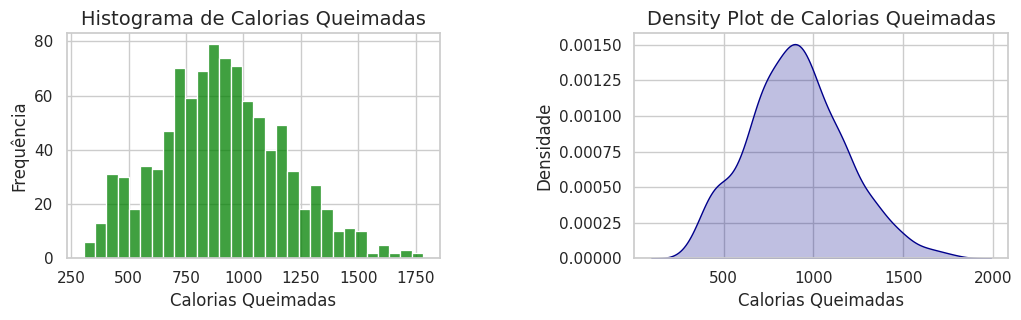

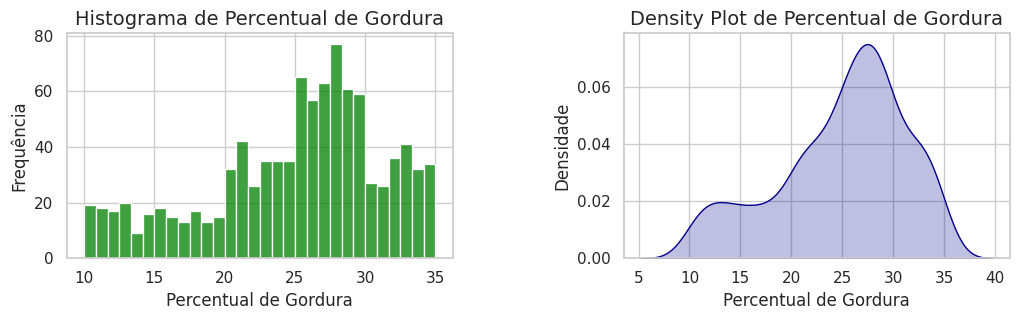

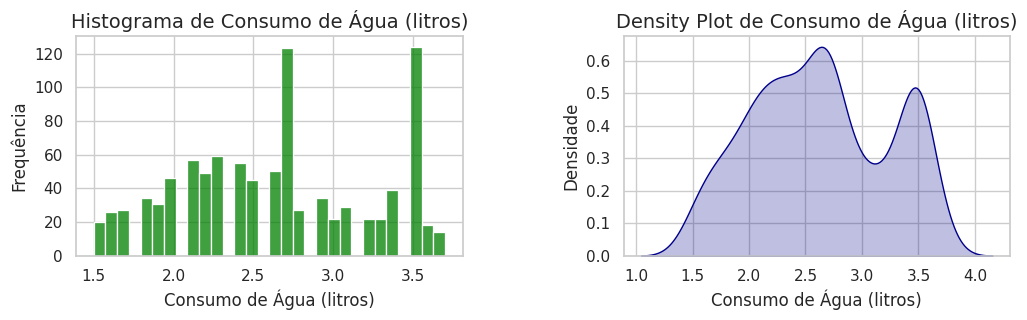

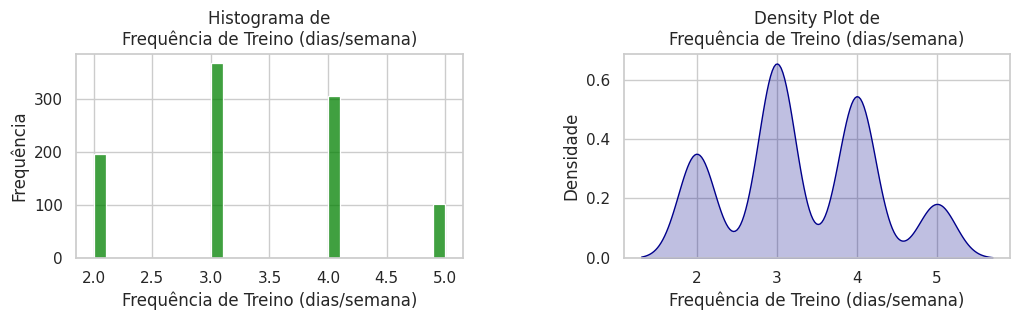

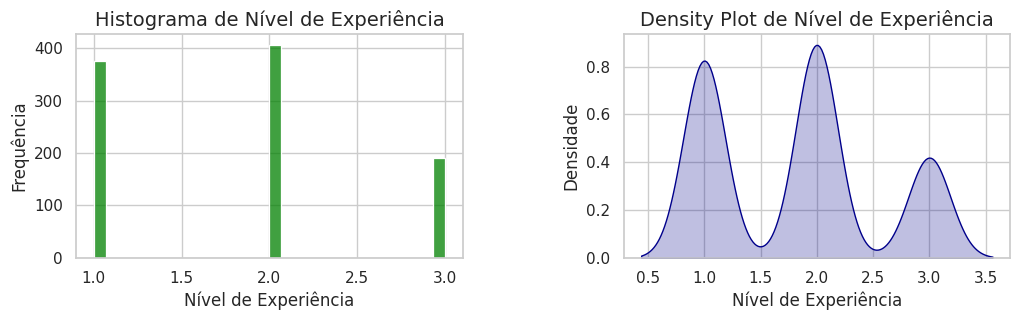

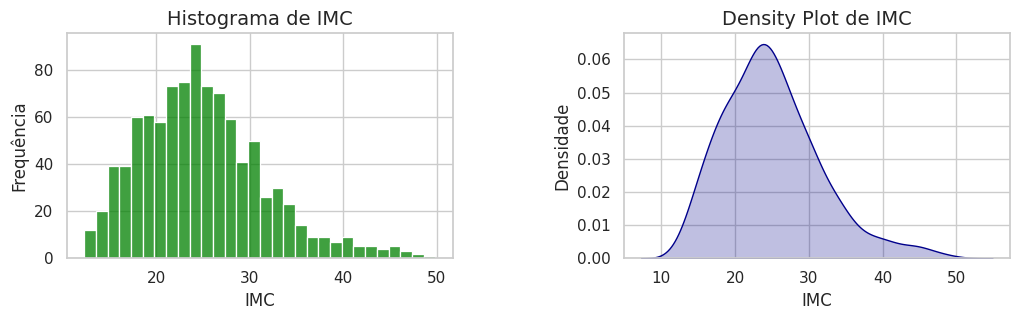

In [ ]:
# Criando histogramas e gráficos de distribuição de densidade
hist_density(df_numerico, hist_color='green', kde_color='darkblue')

Pode-se verificar que grande parte dos atributos possui uma distribuição do tipo normal. No processo de transformação dos dados, essa informação é importante. Em dados que possuem distribuição normal, aplicar a padronização dos mesmos é um processo recomendado no pré-processamento antes da aplicação do modelo de Machine Learning.

É construída também uma matriz de correlação de Pearson para ser possível verificar as correlações entre os atributos.

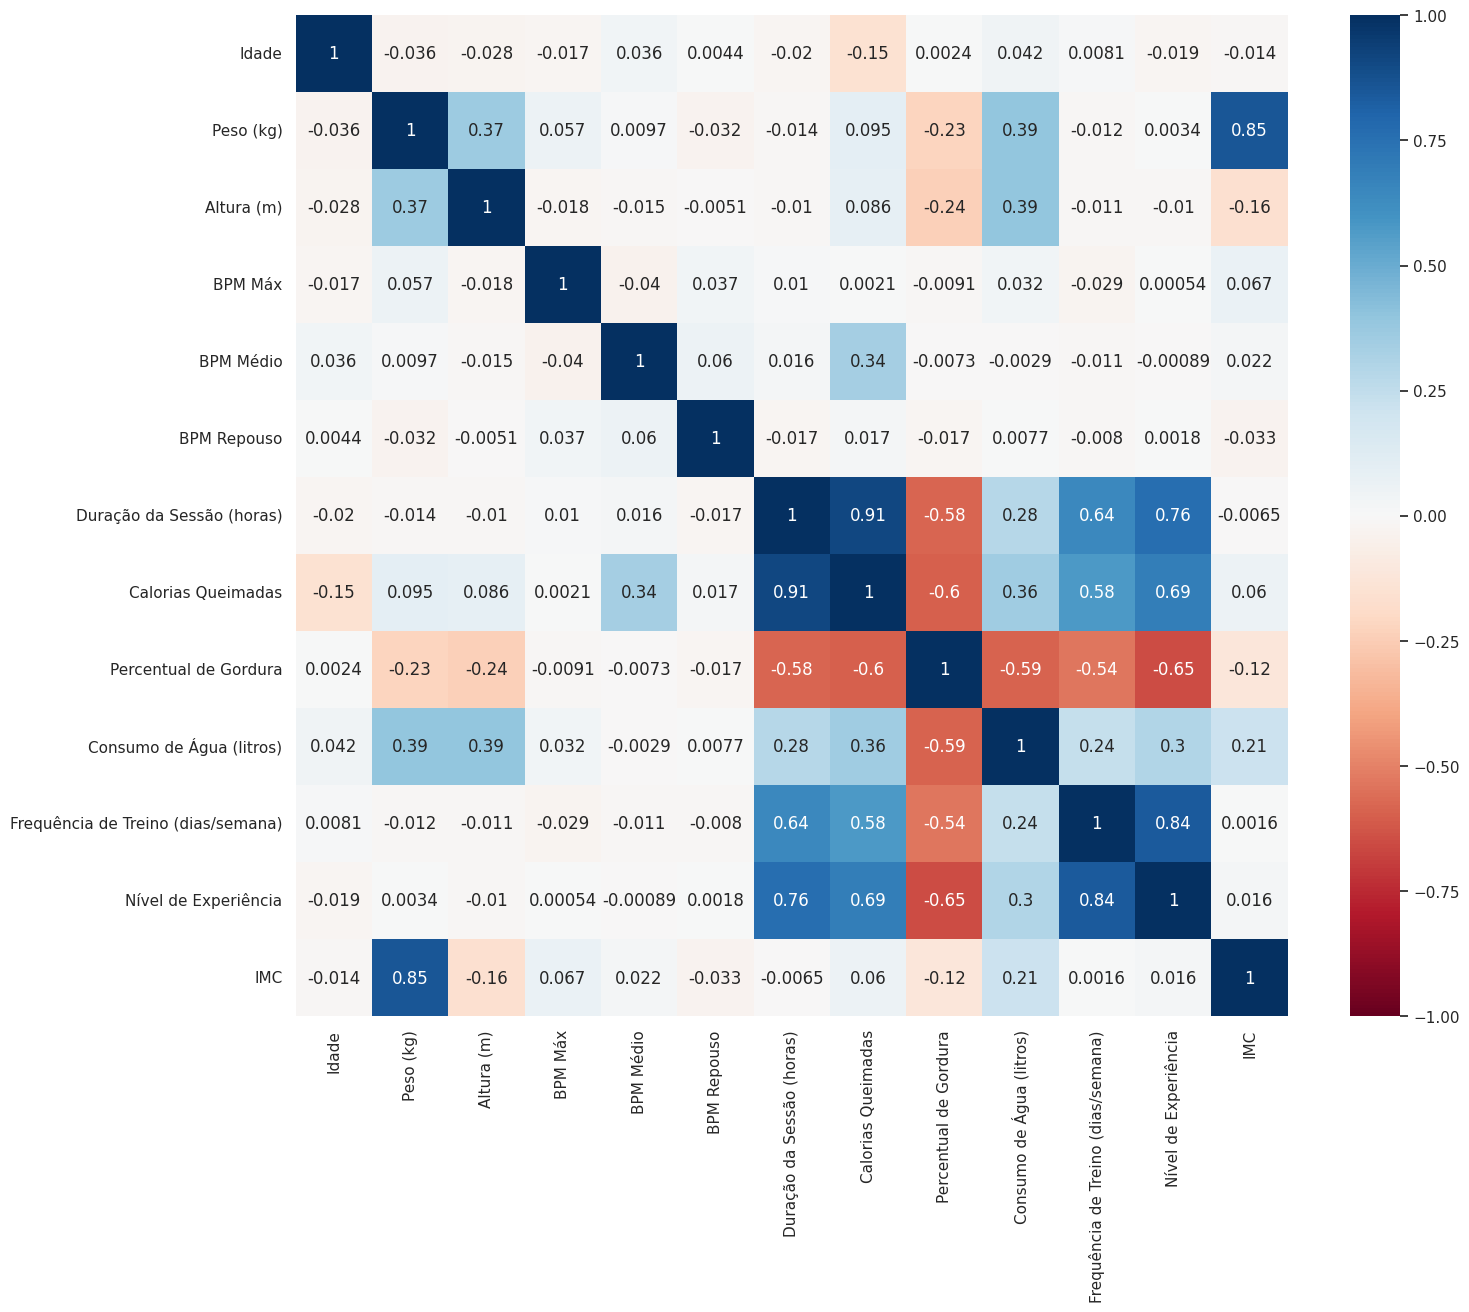

In [54]:
# Gerando a matriz de correlação de Pearson
plt.figure(figsize = (16,13))
sns.heatmap(df_numerico.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);

# Escrever sobre as correlações mais destacadas!!!!

## Construção do Modelo de Machine Learning

### Separação dos dados, pré-processamento e divisão dos conjuntos de treino e teste

Os dados são divididos em bases de treino e teste. Foi escolhida uma divisão da base de dados em 80% para treino e 20% para teste.
O atributo categórico "Gênero" foi considerado nesse processo de divisão. A mesma é realizada de forma que as classes "Male" e "Female" estejam distrubuídas uniformemente entre as bases de treino e teste, reduzindo o risco de viés causado por desequilíbrio entre as bases.

In [ ]:
# Divisão das matrizes
X = dataframe.drop(columns=['Calorias Queimadas'])  # Atributos de predição
y = dataframe['Calorias Queimadas']                 # Atributo alvo

# Garantir a presença do atributo "Gênero"
if 'Gênero' not in X.columns:
    raise ValueError("O atributo 'Gênero' deve estar"
                     "presente no conjunto de dados."
                    )

# Dividir em treino e teste com estratificação no atributo "Gênero"
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=X['Gênero']
                                                    )

# Verificar a distribuição do atributo "Gênero" em treino e teste
print("Distribuição em X_train:")
print(X_train['Gênero'].value_counts(normalize=True))

print("\nDistribuição em X_test:")
print(X_test['Gênero'].value_counts(normalize=True))

Distribuição em X_train:
Gênero
Male      0.525707
Female    0.474293
Name: proportion, dtype: float64

Distribuição em X_test:
Gênero
Male      0.523077
Female    0.476923
Name: proportion, dtype: float64


Após esse processo, é aplicado o One Hot Encoder para transformar as classes dos atributos categóricos em valores numéricos, de modo a ser possível aplicar os modelos de machine learning com esses dados, já que os algoritmos só podem ser executados com dados númericos.

In [ ]:
# Configurar o OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# handle_unknown='ignore' garante que categorias desconhecidas no teste serão ignoradas.

# Ajustar o encoder na base de treino
one_hot_encoder.fit(X_train[['Gênero', 'Tipo de Treino']])

# Aplicar o encoder em ambas as bases
X_train_encoded = one_hot_encoder.transform(X_train[['Gênero', 'Tipo de Treino']])
X_test_encoded = one_hot_encoder.transform(X_test[['Gênero', 'Tipo de Treino']])

# Converter os resultados em DataFrames
nomes_colunas = one_hot_encoder.get_feature_names_out(['Gênero', 'Tipo de Treino'])
X_train_encoded = pd.DataFrame(X_train_encoded, columns=nomes_colunas, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=nomes_colunas, index=X_test.index)

# Concatenar com as demais colunas (excluindo as categóricas originais)
X_train_final = pd.concat([X_train.drop(columns=['Gênero', 'Tipo de Treino']), X_train_encoded], axis=1)
X_test_final = pd.concat([X_test.drop(columns=['Gênero', 'Tipo de Treino']), X_test_encoded], axis=1)

# Exibir as 5 primeiras linhas das bases
print("Base de treino (X_train):")
print(X_train_final.head())

print("\nBase de teste (X_test):")
print(X_test_final.head())

Base de treino (X_train):
     Idade  Peso (kg)  Altura (m)  BPM Máx  BPM Médio  BPM Repouso  \
22      50       71.0        1.68      187        161           70   
749     28       79.6        1.59      181        130           54   
551     30      113.4        1.91      177        137           54   
183     19       87.8        1.78      195        161           72   
277     50       51.5        1.71      199        155           64   

     Duração da Sessão (horas)  Percentual de Gordura  \
22                        1.17                   33.1   
749                       1.49                   28.2   
551                       1.27                   22.2   
183                       1.28                   23.6   
277                       1.48                   20.9   

     Consumo de Água (litros)  Frequência de Treino (dias/semana)  \
22                        2.5                                   2   
749                       1.5                                   3   
551

### Seleção dos atributos para construção dos modelos (Feature Selection)

Após a divisão das bases de treino e teste, além da transformação das classes dos atriutos categóricos, o conjunto de treino será aplicado em vários modelos de regressão. São comparados os resultados para cada modelo em três cenários: dados originais, dados transformados com normalização e dados transformados com padronização.
Antes do treinamento dos modelos, é realizada uma seleção dos melhores atributos para treinamento do modelo atrávés do algoritmo de feature selection. Nesse processo, foi escolhido o método da validação cruzada para o treinamento desses modelos com um número de k-folds igual a 10. O modelo escolhido para esse processo foi a Árvore de Regressão (Decision Tree Regressor) pois esse modelo possui bom desempenho com dados não transformados (normalizados ou padronizados). A escolha desse modelo para esse processo se justifica para otimizar o tempo de processamento de todo o projeto.

In [ ]:
# Exemplo de uso da função
k_values = range(5, min(20, X_train.shape[1] + 1))  # Testar de 5 até o mínimo de 20 ou total de features

# Modelo selecionado
selected_model = DecisionTreeRegressor(random_state=42)

# Executar a seleção de features com o modelo escolhido
feature_selection_results, best_k, best_features = run_feature_selection_comparison(
    X_train_final, y_train, selected_model, k_values=k_values, cv=10
)


Modelo: DecisionTreeRegressor
k=5 -> MSE Médio: 15557.2073, Desvio: 7428.1645
Atributos Selecionados: Duração da Sessão (horas), Percentual de Gordura, Consumo de Água (litros), Frequência de Treino (dias/semana), Nível de Experiência
k=6 -> MSE Médio: 7372.6658, Desvio: 1022.6597
Atributos Selecionados: BPM Médio, Duração da Sessão (horas), Percentual de Gordura, Consumo de Água (litros), Frequência de Treino (dias/semana), Nível de Experiência
k=7 -> MSE Médio: 4820.5096, Desvio: 720.1245
Atributos Selecionados: Idade, BPM Médio, Duração da Sessão (horas), Percentual de Gordura, Consumo de Água (litros), Frequência de Treino (dias/semana), Nível de Experiência
k=8 -> MSE Médio: 4240.0851, Desvio: 940.6905
Atributos Selecionados: Idade, BPM Médio, Duração da Sessão (horas), Percentual de Gordura, Consumo de Água (litros), Frequência de Treino (dias/semana), Nível de Experiência, Gênero_Male
k=9 -> MSE Médio: 4281.2149, Desvio: 795.2428
Atributos Selecionados: Idade, BPM Médio, Duraçã

### Treinamento nos modelos

In [ ]:
# Lista de modelos de regressão
models = {
    'Regressão Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Árvore de Decisão': DecisionTreeRegressor(random_state=42),
    'KNN Regressor': KNeighborsRegressor(),
    'SVR': SVR()
}

# Escalonadores
scalers = {
    'Atributos Originais': None,
    'Com Normalização': MinMaxScaler(),
    'Com Padronização': StandardScaler()
}

# Avaliar modelos utilizando as features selecionadas
results_df, all_cv_results_df = evaluate_models_on_training(
    X_train_final, y_train, models, scalers, best_features, cv=10
)


Cenário: Atributos Originais

Modelo: Regressão Linear
RMSE CV: 39.2133, Desvio: 4.7312

Modelo: Ridge
RMSE CV: 39.4922, Desvio: 4.6723

Modelo: Lasso
RMSE CV: 39.4644, Desvio: 4.6436

Modelo: ElasticNet
RMSE CV: 153.9274, Desvio: 7.8874

Modelo: Random Forest
RMSE CV: 41.7454, Desvio: 4.8809

Modelo: Gradient Boosting
RMSE CV: 21.1531, Desvio: 3.6609

Modelo: Árvore de Decisão
RMSE CV: 64.9603, Desvio: 5.6260

Modelo: KNN Regressor
RMSE CV: 196.4579, Desvio: 8.9991

Modelo: SVR
RMSE CV: 268.3404, Desvio: 23.4952

Cenário: Com Normalização

Modelo: Regressão Linear
RMSE CV: 39.2199, Desvio: 4.7388

Modelo: Ridge
RMSE CV: 40.4992, Desvio: 4.6262

Modelo: Lasso
RMSE CV: 39.6843, Desvio: 5.0441

Modelo: ElasticNet
RMSE CV: 210.6604, Desvio: 17.6779

Modelo: Random Forest
RMSE CV: 41.6309, Desvio: 4.9347

Modelo: Gradient Boosting
RMSE CV: 21.1885, Desvio: 3.6511

Modelo: Árvore de Decisão
RMSE CV: 64.8049, Desvio: 4.9955

Modelo: KNN Regressor
RMSE CV: 102.2394, Desvio: 5.4977

Modelo: S

A partir dos resultados obtidos nos treinamentos dos modelos selecionados, pode-se construir um gráfico onde é possível visualizar como estão distribuídos os resultados dos cinco melhores modelos em relação ao valor da métrica definida (MSE - Erro Médio Quadrático) a partir dos dados dos resultados da validação cruzada realizada para cada um deles.

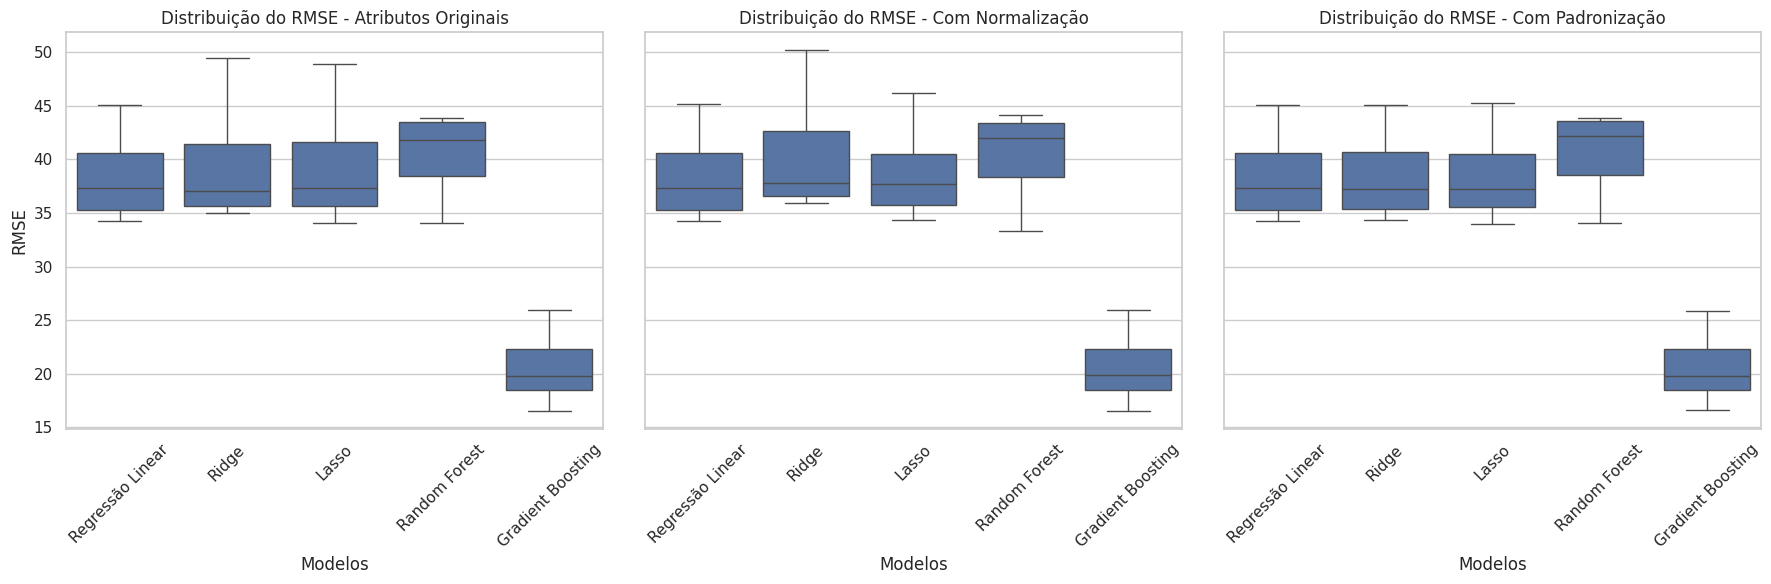

In [ ]:
# Criar uma figura com três subgráficos (um para cada cenário)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Cenários: Atributos Originais, Com Normalização e Com Padronização
cenarios = ['Atributos Originais', 'Com Normalização', 'Com Padronização']

# Para cada cenário, plotar um boxplot separado
for i, cenario in enumerate(cenarios):
    ax = axes[i]

    # Filtrar os dados para o cenário atual
    cenario_data = all_cv_results_df[all_cv_results_df['Cenário'] == cenario]

    # Ordenar os modelos por MSE e pegar os 5 melhores (menores RMSE)
    top_5_models = cenario_data.groupby('Modelo')['RMSE'].mean().nsmallest(5).index
    top_5_data = cenario_data[cenario_data['Modelo'].isin(top_5_models)]

    # Plotar o boxplot para os 5 melhores modelos do cenário
    sns.boxplot(
        data=top_5_data,
        x='Modelo', y='RMSE', ax=ax,
        showfliers=False
    )

    ax.set_title(f'Distribuição do RMSE - {cenario}')
    ax.set_xlabel('Modelos')
    ax.set_ylabel('RMSE')
    ax.tick_params(axis='x', rotation=45)  # Rotacionar rótulos do eixo x

# Ajustar o layout para evitar sobreposição de texto
plt.tight_layout()
plt.show()

É possível verificar que o Modelo Gradient Boosting Regressor apresentou o menor valor na métrica de avaliação definida. Nos três cenários os valores ficaram bem próximos. Para selecionar o melhor modelo para esse projeto, são comparados os resultados das médias dos três e justificada a escolha de um deles.


Plotando curva de aprendizado para: Gradient Boosting com escalonador Atributos Originais

Plotando curva de aprendizado para: Gradient Boosting com escalonador Com Padronização

Plotando curva de aprendizado para: Gradient Boosting com escalonador Com Normalização

Plotando curva de aprendizado para: Lasso com escalonador Com Padronização

Plotando curva de aprendizado para: Regressão Linear com escalonador Com Padronização


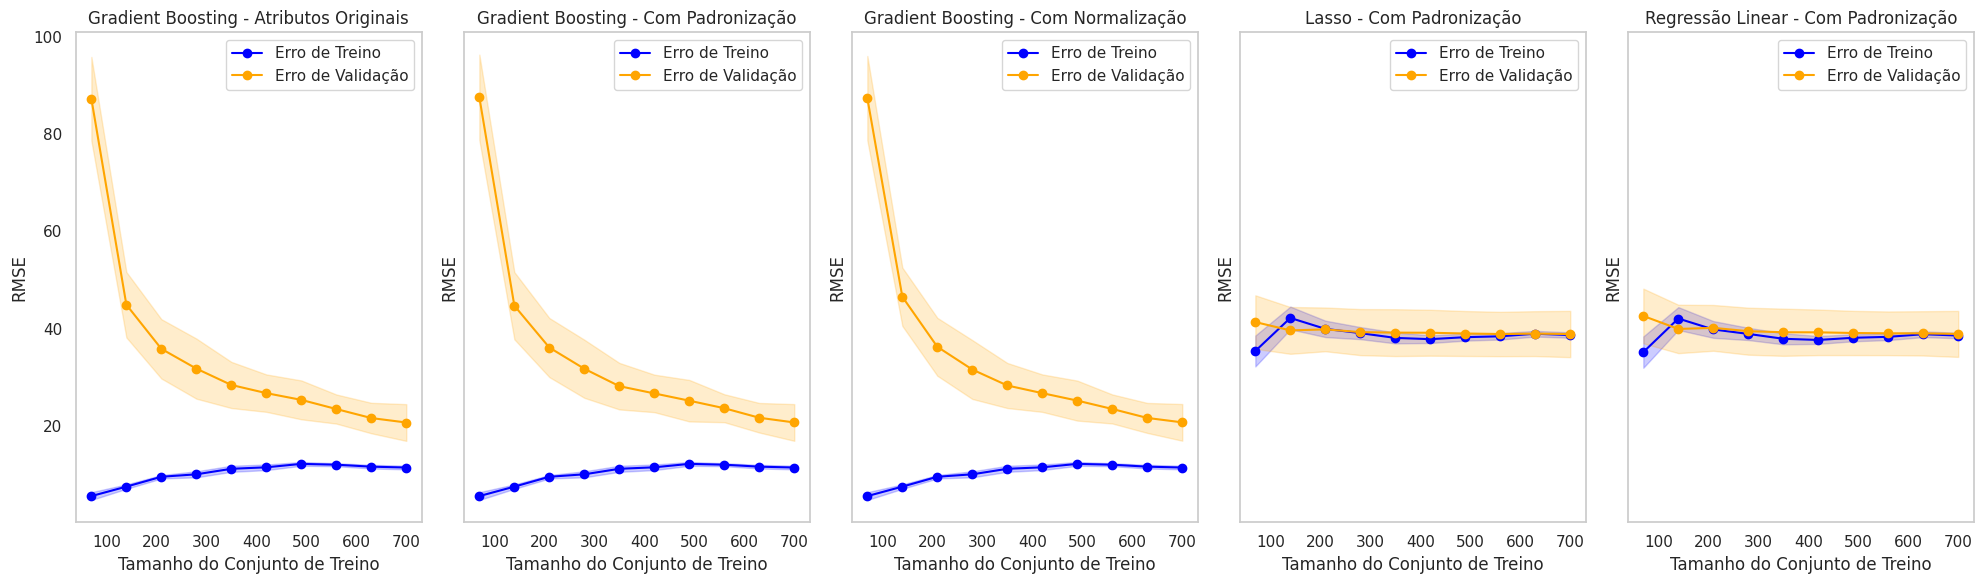

In [ ]:
# Após realizar o treinamento e obter os resultados, usar a função:
# Filtrar os 5 melhores modelos com base na métrica de RMSE CV
top_5_models = results_df.head(5)

# Plotar as curvas de aprendizado para os 5 melhores
plot_learning_curves(X_train_final, y_train, models, scalers, best_features, top_5_models, cv=10)

### Otimização dos hiperparâmetros e aplicação na base de treino para os modelos selecionados

Com a escolha do modelo Gradient Boosting Regressor para o projeto, é realizada uma otimização dos hiperparâmetros relacionados a esse modelo, de modo a se obter o melhor desempenho possível. Para isso, é utilizada a biblioteca Gridsearch.

In [ ]:
# Lista de hiperparâmetros para cada modelo
param_grids = {
    'Regressão Linear': {},  # Sem hiperparâmetros para ajustar
    'Ridge': {
        'alpha': [0.01, 0.1, 1, 5, 10, 50, 100, 200]  # Mais opções para alpha
    },
    'Lasso': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50],  # Mais opções para alpha
    },
    'ElasticNet': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50],  # Mais valores para alpha
        'l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95],  # Mais valores para l1_ratio
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 500, 1000],  # Aumento no número de estimadores
        'max_depth': [None, 10, 20, 30, 40, 50],  # Mais valores para max_depth
        'min_samples_split': [2, 5, 10, 20, 50],  # Mais opções para min_samples_split
        'min_samples_leaf': [1, 2, 4, 10],  # Parâmetro adicional: min_samples_leaf
        'max_features': ['auto', 'sqrt', 'log2'],  # Parâmetro adicional: max_features
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],  # Aumento no número de estimadores
        'learning_rate': [0.01, 0.05, 0.1],  # Mais valores para learning_rate
        'max_depth': [3, 5],  # Mais opções para max_depth
        'subsample': [0.7, 0.8, 0.9],  # Parâmetro adicional: subsample
        'min_samples_split': [2, 5],  # Parâmetro adicional: min_samples_split
        'min_samples_leaf': [1, 2, 5],  # Parâmetro adicional: min_samples_leaf
    },
    'Árvore de Decisão': {
        'max_depth': [None, 10, 20, 30, 40, 50],  # Mais valores para max_depth
        'min_samples_split': [2, 5, 10, 20],  # Mais opções para min_samples_split
        'min_samples_leaf': [1, 2, 5],  # Parâmetro adicional: min_samples_leaf
        'criterion': ['gini', 'entropy'],  # Parâmetro adicional: criterion
    },
    'KNN Regressor': {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 20],  # Mais opções para n_neighbors
        'weights': ['uniform', 'distance'],  # Mantido, sem alteração
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Parâmetro adicional: algorithm
        'leaf_size': [20, 30, 40],  # Parâmetro adicional: leaf_size
    },
    'SVR': {
        'kernel': ['linear', 'rbf', 'poly'],  # Adicionando kernel 'poly'
        'C': [0.01, 0.1, 1, 10, 100, 1000],  # Mais opções para C
        'epsilon': [0.01, 0.05, 0.1, 0.2, 0.3],  # Mais valores para epsilon
        'degree': [2, 3, 4],  # Parâmetro adicional: degree
        'gamma': ['scale', 'auto', 0.1, 0.01],  # Parâmetro adicional: gamma
    }
}

# Selecionar os 5 melhores modelos do DataFrame de resultados
top_5_models = results_df.head(5)

# Aplicar Grid Search em cada um dos 5 melhores modelos
grid_search_results = []

for _, row in top_5_models.iterrows():
    model_name = row['Modelo']
    scaler_name = row['Cenário']
    print(f"\nAplicando Grid Search no modelo: {model_name} com escalonador: {scaler_name}")

    # Configurar dados escalonados
    if scaler_name == 'Atributos Originais':
        X_train_scaled = X_train_final[best_features]
    else:
        scaler = scalers[scaler_name]
        X_train_scaled = scaler.fit_transform(X_train_final[best_features])

    # Recuperar o modelo e o grid de hiperparâmetros
    model = models[model_name]
    param_grid = param_grids.get(model_name, {})

    # Configurar e executar o Grid Search
    grid_search = GridSearchCV(
        model, param_grid, scoring='neg_mean_squared_error',
        cv=5, n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_scaled, y_train)

    # Salvar os melhores resultados
    best_rmse = np.sqrt(-grid_search.best_score_)
    grid_search_results.append({
        'Modelo': model_name,
        'Cenário': scaler_name,
        'Melhor RMSE': best_rmse,
        'Melhores Hiperparâmetros': grid_search.best_params_
    })

# Converter resultados em DataFrame para análise
grid_search_results_df = pd.DataFrame(grid_search_results)

# Exibir os resultados do Grid Search
print("\nResultados do Grid Search para os 5 melhores modelos:")
grid_search_results_df.sample(5)


Aplicando Grid Search no modelo: Gradient Boosting com escalonador: Atributos Originais
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Aplicando Grid Search no modelo: Gradient Boosting com escalonador: Com Padronização
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Aplicando Grid Search no modelo: Gradient Boosting com escalonador: Com Normalização
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Aplicando Grid Search no modelo: Lasso com escalonador: Com Padronização
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Aplicando Grid Search no modelo: Regressão Linear com escalonador: Com Padronização
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Resultados do Grid Search para os 5 melhores modelos:


,Modelo,Cenário,Melhor RMSE,Melhores Hiperparâmetros
3,Lasso,Com Padronização,39.250984,{'alpha': 1}
4,Regressão Linear,Com Padronização,39.282185,{}
2,Gradient Boosting,Com Normalização,17.268704,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."
1,Gradient Boosting,Com Padronização,17.481235,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."
0,Gradient Boosting,Atributos Originais,17.619149,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."


Pode-se inferir que com a otimização dos hiperparâmetros, foi possível diminuir um pouco mais o erro em comparação com o processo anterior.


Plotando curva de aprendizado para: Gradient Boosting com escalonador Atributos Originais

Plotando curva de aprendizado para: Gradient Boosting com escalonador Com Padronização

Plotando curva de aprendizado para: Gradient Boosting com escalonador Com Normalização

Plotando curva de aprendizado para: Lasso com escalonador Com Padronização

Plotando curva de aprendizado para: Regressão Linear com escalonador Com Padronização


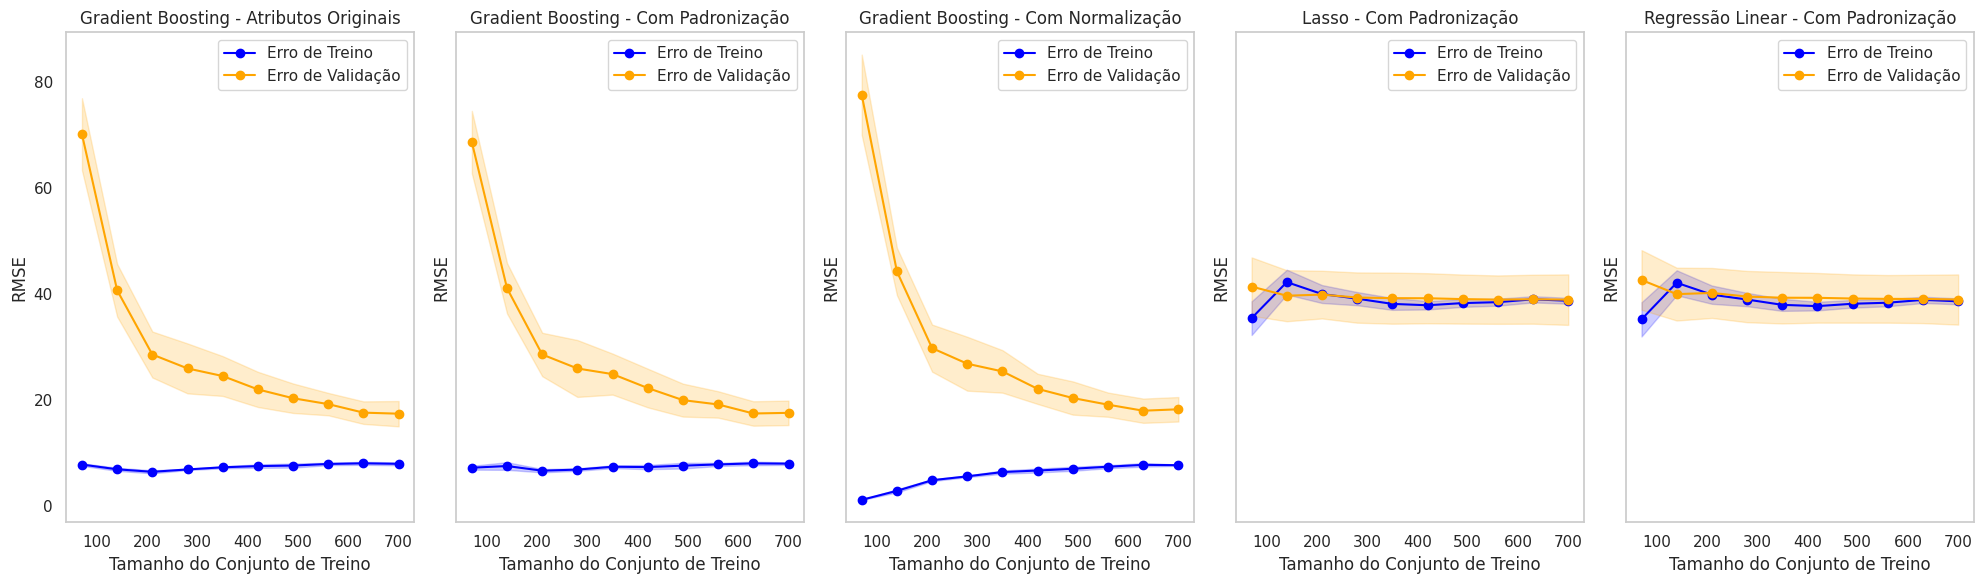

In [ ]:
def plot_learning_curves_post_grid_search(X_train, y_train, models, scalers, selected_features, grid_search_results_df, cv=10):
    """
    Gera as curvas de aprendizado para os modelos otimizados pelo Grid Search.

    Parâmetros:
        - X_train: DataFrame com os atributos de treino.
        - y_train: Série ou array com o alvo de treino.
        - models: Dicionário com os modelos disponíveis.
        - scalers: Dicionário de escalonadores.
        - selected_features: Lista com as features selecionadas.
        - grid_search_results_df: DataFrame com os resultados do Grid Search (modelos otimizados).
        - cv: Número de folds para validação cruzada.
    """
    fig, axes = plt.subplots(1, len(grid_search_results_df), figsize=(20, 6), sharey=True)
    axes = axes.ravel()  # Facilita a iteração

    # Para cada modelo otimizado
    for idx, (_, row) in enumerate(grid_search_results_df.iterrows()):
        model_name = row['Modelo']
        scaler_name = row['Cenário']
        best_params = row['Melhores Hiperparâmetros']
        print(f"\nPlotando curva de aprendizado para: {model_name} com escalonador {scaler_name}")

        # Configurar os dados com o escalonador
        scaler = scalers[scaler_name]
        X_train_selected = X_train[selected_features]
        if scaler is not None:
            scaler.fit(X_train_selected)
            X_train_selected = scaler.transform(X_train_selected)

        # Obter o modelo otimizado
        model = models[model_name]
        model.set_params(**best_params)  # Atualiza os hiperparâmetros do modelo com os melhores encontrados

        # Calcular a curva de aprendizado
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train_selected, y_train, cv=cv, scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )

        # Transformar as pontuações de erro negativo para RMSE
        train_rmse = np.sqrt(-train_scores)
        val_rmse = np.sqrt(-val_scores)

        # Média e desvio padrão para treino e validação
        train_mean = train_rmse.mean(axis=1)
        train_std = train_rmse.std(axis=1)
        val_mean = val_rmse.mean(axis=1)
        val_std = val_rmse.std(axis=1)

        # Plotar a curva de aprendizado
        ax = axes[idx]
        ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Erro de Treino')
        ax.plot(train_sizes, val_mean, 'o-', color='orange', label='Erro de Validação')
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
        ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)
        ax.set_title(f"{model_name} - {scaler_name}")
        ax.set_xlabel("Tamanho do Conjunto de Treino")
        ax.set_ylabel("RMSE")
        ax.legend(loc="best")
        ax.grid()

    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Uso da função
plot_learning_curves_post_grid_search(
    X_train_final, y_train, models, scalers, best_features,
    grid_search_results_df, cv=10
)

### Aplicação do modelo na base de teste

A partir dos hiperparâmetros selecionados, os modelo são aplicados na base testes e são avaliadas as métricas de desempenho dos mesmos.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Lista para armazenar os resultados de teste
test_results = []

# Preparar a base de teste com o mesmo escalonamento aplicado aos dados de treino
for _, row in grid_search_results_df.iterrows():
    model_name = row['Modelo']
    scaler_name = row['Cenário']
    best_params = row['Melhores Hiperparâmetros']

    print(f"\nTestando o modelo: {model_name} com escalonador: {scaler_name}")

    # Configurar o escalonador
    if scaler_name == 'Atributos Originais':
        X_test_scaled = X_test_final[best_features]
    else:
        scaler = scalers[scaler_name]
        X_test_scaled = scaler.transform(X_test_final[best_features])

    # Recuperar o modelo e configurar com os melhores parâmetros
    model = models[model_name]
    model.set_params(**best_params)

    # Treinar o modelo nos dados de treino
    model.fit(X_train_scaled, y_train)

    # Fazer previsões na base de teste
    y_pred = model.predict(X_test_scaled)

    # Calcular o RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Armazenar os resultados
    test_results.append({
        'Modelo': model_name,
        'Cenário': scaler_name,
        'RMSE no Teste': rmse
    })

# Converter os resultados para um DataFrame para visualização
test_results_df = pd.DataFrame(test_results)

# Exibir os resultados dos 5 modelos no conjunto de teste
print("\nResultados de RMSE no conjunto de teste:")
print(test_results_df.sort_values(by='RMSE no Teste'))


Testando o modelo: Gradient Boosting com escalonador: Atributos Originais

Testando o modelo: Gradient Boosting com escalonador: Com Padronização

Testando o modelo: Gradient Boosting com escalonador: Com Normalização

Testando o modelo: Lasso com escalonador: Com Padronização

Testando o modelo: Regressão Linear com escalonador: Com Padronização

Resultados de RMSE no conjunto de teste:
              Modelo              Cenário  RMSE no Teste
1  Gradient Boosting     Com Padronização      18.271884
4   Regressão Linear     Com Padronização      43.516125
3              Lasso     Com Padronização      43.916503
2  Gradient Boosting     Com Normalização     260.278641
0  Gradient Boosting  Atributos Originais     457.482740


Foi identificado que o modelo Gradient Boosting com os Atributos Originais não obteve um desempenho satisfatório com o conjunto de teste. Devido a elevação do valor da métrica de desempenho, pode-se verificar que esse modelo apresentou overfitting, se ajustando em demasia aos dados de treino.

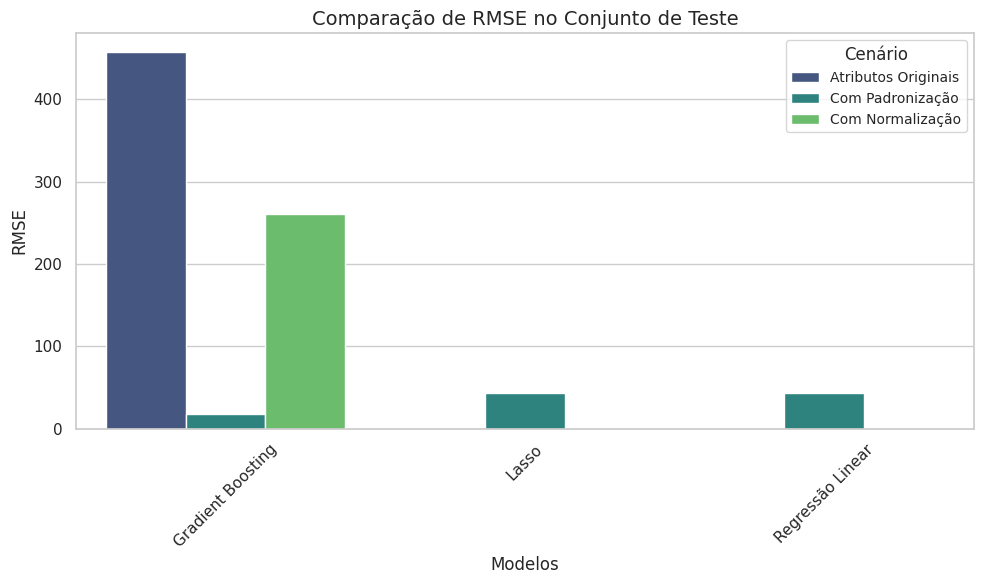

In [ ]:
# Plotar desempenho dos modelos no conjunto de teste (RMSE)
plt.figure(figsize=(10, 6))

# Gráfico de barras para RMSE
sns.barplot(
    data=test_results_df, x='Modelo', y='RMSE no Teste', hue='Cenário',
    palette='viridis'
)

plt.title('Comparação de RMSE no Conjunto de Teste', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('Modelos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Cenário', fontsize=10)
plt.tight_layout()
plt.show()



## Considerações finais